In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat
from math import sqrt
import numpy as np
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM

In [2]:
df = pd.read_csv('../input/apple-stock-prices-20152020/AAPL.csv')
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [3]:
df = df.drop(df.columns[[0,1]],axis=1)
df.drop(['splitFactor'],axis=1,inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1258 non-null   object 
 1   close      1258 non-null   float64
 2   high       1258 non-null   float64
 3   low        1258 non-null   float64
 4   open       1258 non-null   float64
 5   volume     1258 non-null   int64  
 6   adjClose   1258 non-null   float64
 7   adjHigh    1258 non-null   float64
 8   adjLow     1258 non-null   float64
 9   adjOpen    1258 non-null   float64
 10  adjVolume  1258 non-null   int64  
 11  divCash    1258 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 118.1+ KB


In [6]:
df.date = pd.to_datetime(df.date)

In [7]:
df.date = df.date.dt.date

In [8]:
df.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash
0,2015-05-27,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0
1,2015-05-28,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0
2,2015-05-29,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0
3,2015-06-01,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0
4,2015-06-02,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0


In [9]:
df.isnull().sum()

date         0
close        0
high         0
low          0
open         0
volume       0
adjClose     0
adjHigh      0
adjLow       0
adjOpen      0
adjVolume    0
divCash      0
dtype: int64

In [10]:
df = df.set_index('date')

In [11]:
df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash
date,,,,,,,,,,,
2015-05-27,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0
2015-05-28,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0
2015-05-29,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0
2015-06-01,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0
2015-06-02,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0


<AxesSubplot:xlabel='date'>

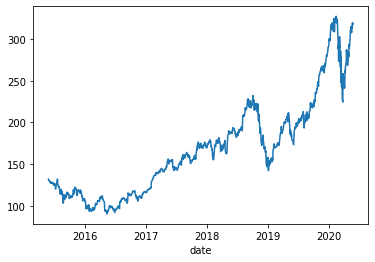

In [12]:
df.close.plot()

<AxesSubplot:xlabel='date'>

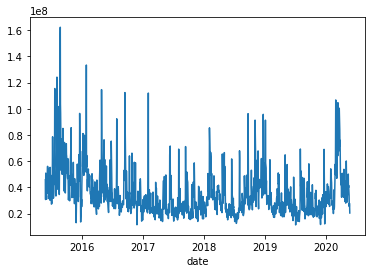

In [13]:
df.adjVolume.plot()

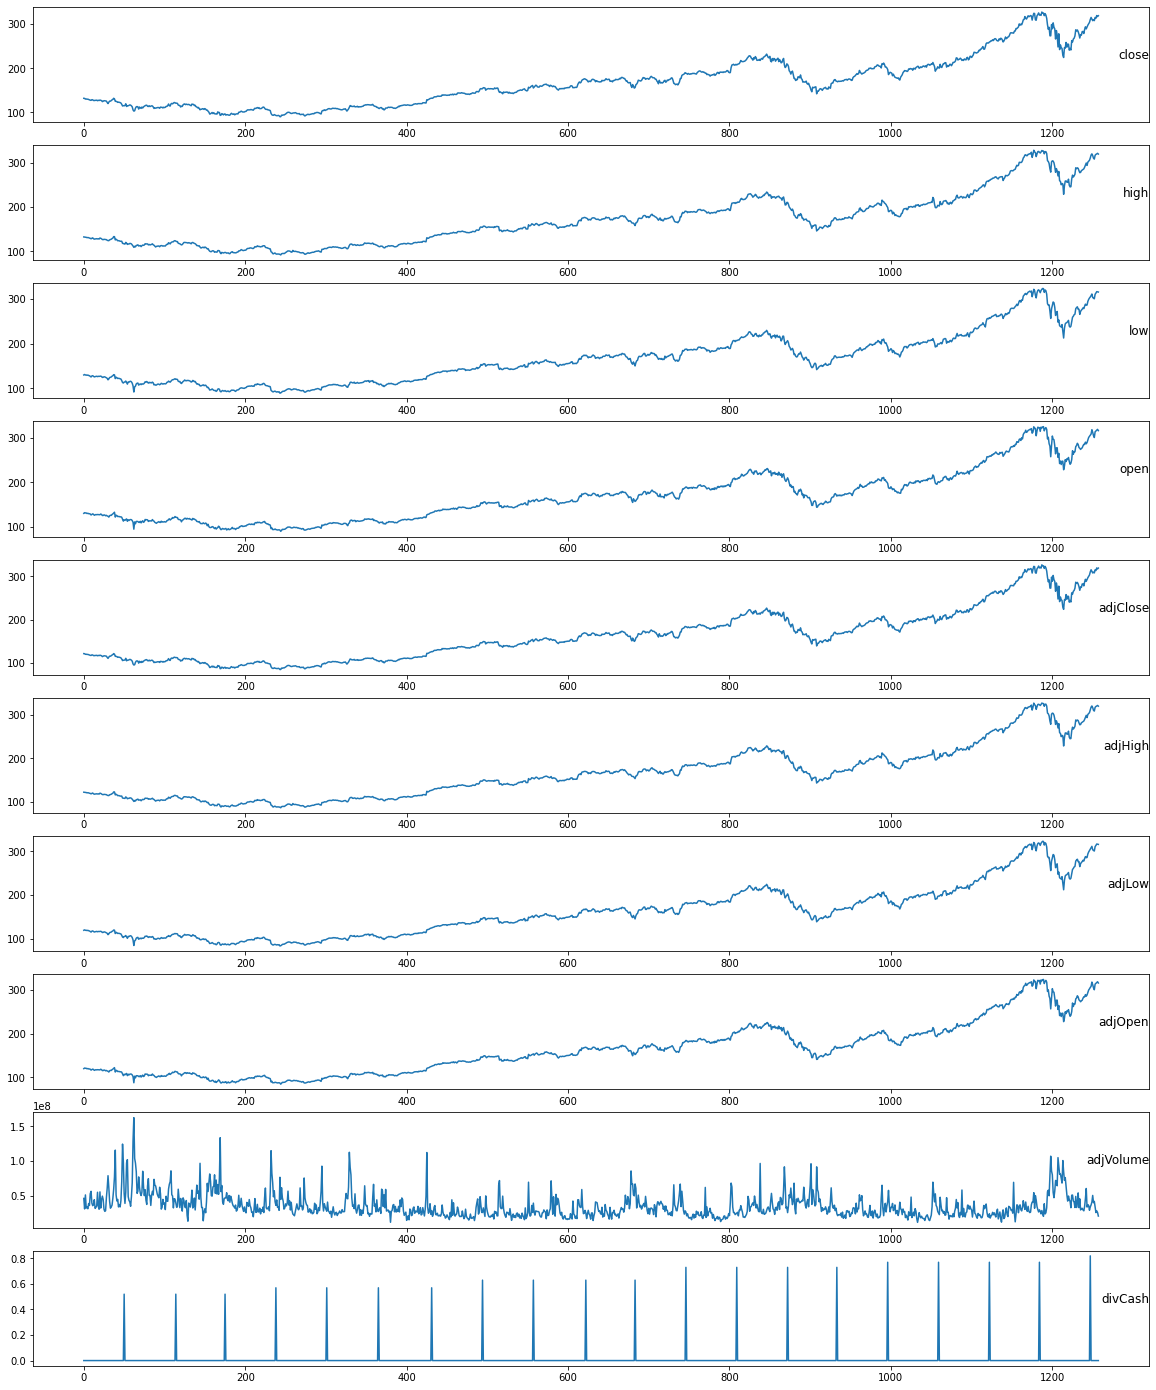

In [14]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10]
i = 1
# plot each column
plt.figure(figsize=(20,25))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [16]:
# convert series to supervised
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
values = df.values
values = values.astype('float32')

In [18]:
values

array([[1.3204500e+02, 1.3225999e+02, 1.3005000e+02, ..., 1.2011136e+02,
        4.5833248e+07, 0.0000000e+00],
       [1.3178000e+02, 1.3195000e+02, 1.3110001e+02, ..., 1.2151208e+02,
        3.0733308e+07, 0.0000000e+00],
       [1.3028000e+02, 1.3145000e+02, 1.2989999e+02, ..., 1.2093152e+02,
        5.0884452e+07, 0.0000000e+00],
       ...,
       [3.1923001e+02, 3.1951999e+02, 3.1620001e+02, ..., 3.1667999e+02,
        2.7876216e+07, 0.0000000e+00],
       [3.1685001e+02, 3.2089001e+02, 3.1587000e+02, ..., 3.1866000e+02,
        2.5672212e+07, 0.0000000e+00],
       [3.1889001e+02, 3.1923001e+02, 3.1535001e+02, ..., 3.1576999e+02,
        2.0450754e+07, 0.0000000e+00]], dtype=float32)

In [19]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
df_new = series_to_supervised(scaled, 1, 1)
print(df_new.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.176074   0.171860   0.173508   0.171857   0.228522   0.152158   
2   0.174956   0.170548   0.177997   0.178333   0.128419   0.151146   
3   0.168623   0.168431   0.172866   0.175649   0.262008   0.145419   
4   0.169699   0.168177   0.173508   0.175521   0.137564   0.146393   
5   0.167272   0.165065   0.170387   0.169812   0.147872   0.144198   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var2(t)   var3(t)  \
1   0.148554   0.149806   0.148290    0.228522  ...  0.170548  0.177997   
2   0.147365   0.153865   0.154145    0.128419  ...  0.168431  0.172866   
3   0.145446   0.149226   0.151718    0.262008  ...  0.168177  0.173508   
4   0.145216   0.149806   0.151603    0.137564  ...  0.165065  0.170387   
5   0.142396   0.146984   0.146441    0.147872  ...  0.166272  0.172866   

    var4(t)   var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  var10(t)  \
1  0.178333  0.128419  0.151146  0.147365  0.15

In [20]:
df_new.drop(df_new.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)
print(df_new.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.176074   0.171860   0.173508   0.171857   0.228522   0.152158   
2   0.174956   0.170548   0.177997   0.178333   0.128419   0.151146   
3   0.168623   0.168431   0.172866   0.175649   0.262008   0.145419   
4   0.169699   0.168177   0.173508   0.175521   0.137564   0.146393   
5   0.167272   0.165065   0.170387   0.169812   0.147872   0.144198   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)   var1(t)  
1   0.148554   0.149806   0.148290    0.228522         0.0  0.174956  
2   0.147365   0.153865   0.154145    0.128419         0.0  0.168623  
3   0.145446   0.149226   0.151718    0.262008         0.0  0.169699  
4   0.145216   0.149806   0.151603    0.137564         0.0  0.167272  
5   0.142396   0.146984   0.146441    0.147872         0.0  0.167947  


In [21]:
df_new.shape

(1257, 12)

In [22]:
# split into train and test sets
values = df_new.values
n_train_days = 365 * 2  #2 years
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(730, 1, 11) (730,) (527, 1, 11) (527,)


2022-07-07 06:30:38.474440: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-07 06:30:39.162792: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
11/11 - 5s - loss: 0.1432 - val_loss: 0.4559
Epoch 2/50
11/11 - 0s - loss: 0.0907 - val_loss: 0.3406
Epoch 3/50
11/11 - 0s - loss: 0.0658 - val_loss: 0.2344
Epoch 4/50
11/11 - 0s - loss: 0.0589 - val_loss: 0.1438
Epoch 5/50
11/11 - 0s - loss: 0.0559 - val_loss: 0.0831
Epoch 6/50
11/11 - 0s - loss: 0.0497 - val_loss: 0.0623
Epoch 7/50
11/11 - 0s - loss: 0.0353 - val_loss: 0.0257
Epoch 8/50
11/11 - 0s - loss: 0.0239 - val_loss: 0.0281
Epoch 9/50
11/11 - 0s - loss: 0.0170 - val_loss: 0.0599
Epoch 10/50
11/11 - 0s - loss: 0.0161 - val_loss: 0.0667
Epoch 11/50
11/11 - 0s - loss: 0.0158 - val_loss: 0.0589
Epoch 12/50
11/11 - 0s - loss: 0.0151 - val_loss: 0.0476
Epoch 13/50
11/11 - 0s - loss: 0.0148 - val_loss: 0.0486
Epoch 14/50
11/11 - 0s - loss: 0.0143 - val_loss: 0.0535
Epoch 15/50
11/11 - 0s - loss: 0.0145 - val_loss: 0.0490
Epoch 16/50
11/11 - 0s - loss: 0.0141 - val_loss: 0.0522
Epoch 17/50
11/11 - 0s - loss: 0.0149 - val_loss: 0.0482
Epoch 18/50
11/11 - 0s - loss: 0.0140 - 

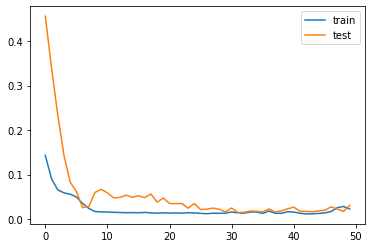

In [23]:
# design network
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 10.372


In [25]:
result_comp = pd.DataFrame(list(zip(inv_y, inv_yhat)),
               columns =['Close_Price_Real', 'Close_Price_Forecast'])

In [26]:
result_comp.head()

,Close_Price_Real,Close_Price_Forecast
0,165.720001,172.792130
1,165.240005,168.148926
2,162.940002,165.167160
3,163.649994,163.457611
4,164.220001,162.854660


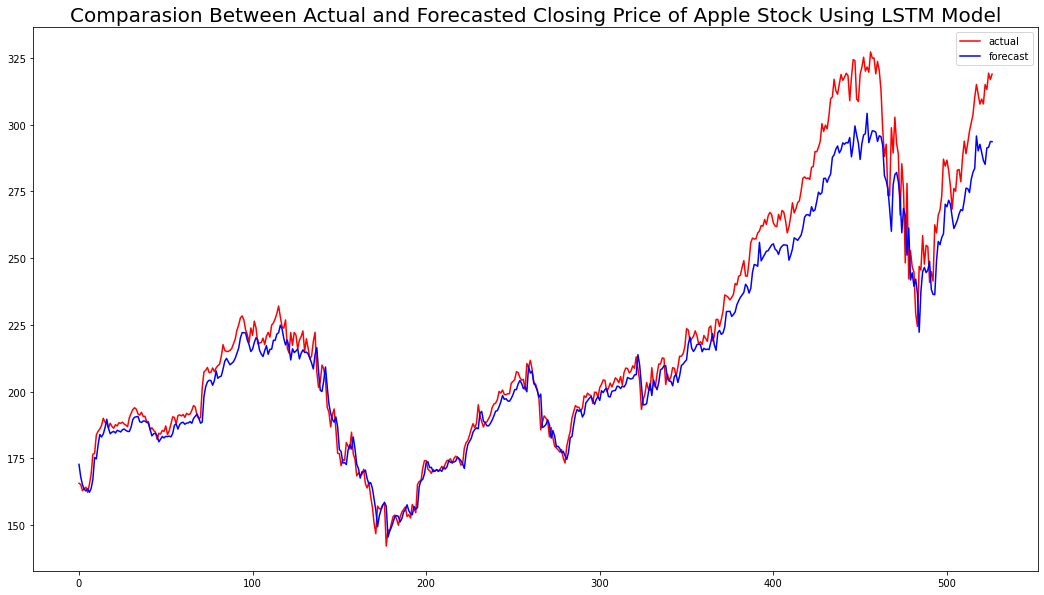

In [27]:
plt.figure(figsize=(18,10))
plt.plot(result_comp['Close_Price_Real'],label='actual',color='red')
plt.plot(result_comp['Close_Price_Forecast'],label='forecast',color='blue')
plt.title('Comparasion Between Actual and Forecasted Closing Price of Apple Stock Using LSTM Model',fontsize=20)
plt.legend()

In [28]:
model.save('_Stock_Price_Model_LSTM.h5')
print("Saved")

Saved
